**Importing the data**

In [ ]:
# imports
from IPython.display import clear_output
from PIL import Image
import os
import json
# clear
clear_output(wait=True)
# installing kaggle
!pip install -q kaggle
# user and key info
info = {"username":"jackbellamy","key":"3442898ba5e904ac3a48eb5b59398805"}
# opening file
json_object = json.dumps(info, indent=4)
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# copying data to content file of kaggle which can be found on the left hand side of the screen
if not (os.path.exists("/content/nfl-big-data-bowl-2022")):
  !kaggle competitions download -c nfl-big-data-bowl-2022
  !mkdir nfl-big-data-bowl-2022
  !unzip nfl-big-data-bowl-2022.zip -d nfl-big-data-bowl-2022

**Calling data files to variables**

In [2]:
import pandas as pd
# reading the data to variables
scouting = pd.read_csv("/content/nfl-big-data-bowl-2022/PFFScoutingData.csv")
games = pd.read_csv("/content/nfl-big-data-bowl-2022/games.csv")
players = pd.read_csv("/content/nfl-big-data-bowl-2022/players.csv")
plays = pd.read_csv("/content/nfl-big-data-bowl-2022/plays.csv")
tracking2018 = pd.read_csv("/content/nfl-big-data-bowl-2022/tracking2018.csv")
tracking2019 = pd.read_csv("/content/nfl-big-data-bowl-2022/tracking2019.csv")
tracking2020 = pd.read_csv("/content/nfl-big-data-bowl-2022/tracking2020.csv")

**Data sizes**

In [3]:
data = [scouting,games,players,plays,tracking2018,tracking2019,tracking2020]
# loop
for name in data:
  print(name.shape)

(19979, 20)
(764, 7)
(2732, 7)
(19979, 25)
(12777351, 18)
(12170933, 18)
(11821701, 18)


This shows the dataset set to be massive therefore as thid is supposed to be a 6 week project probably best to go for quality over quantity.

**Viewing data**

trying to spot anything that needs cleaning

In [ ]:
# shows the first n rows of the data, can change this by changing the n value
# plays.head()


**Cleaning data**

The 'birthDate' and 'collegeName' columns of 'players.csv' have missing values

Need to convert 'height' column values from 'players.csv' from the format feet-inch or inch to feet to allow for calculations etc

The 'birthDate' column should be parsed as DateTime instead of object?

Need to split YYYY (Year) from YYYY-MM-DD date format to allow for calculations etc

Replace abbrevated words with keywords in general, for example position of type of kick

Remove null values from the dataset for calculations etc

**Cleaning scouting**

In [20]:
scouting.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,...,puntRushers,specialTeamsSafeties,vises,kickContactType,kick_type_name,missed_tackler_team,missed_tackler_numbers,formation_front,formation_mid,formation_back
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,...,NaN,PHI 23; PHI 27,NaN,NaN,Deep,NaN,NaN,8.0,0.0,2.0
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,...,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,Normal,PHI,[57],NaN,NaN,NaN
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,PHI 58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,...,NaN,ATL 17; ATL 22,NaN,NaN,Deep,ATL,[83],8.0,0.0,2.0
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,...,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF,Normal,NaN,NaN,NaN,NaN,NaN


converting letters to names (this can be generalised)

In [6]:
# converting letters to names (this can be generalised)
# 'kickType': abbreviated
kick_types = ['D','F','K','O','P','Q','S','B','N','R','A']
# kick type full names
kick_type_names = ['Deep','Flat','Free','Obvious','Pooch','Squib','Surprise','Deep','Normal','Rugby','Aussie']
# new names
kick_type_name = []
# looping through
for i in scouting["kickType"]:
  # filtering out NaN values
  if i in kick_types:
    index = kick_types.index(i)
    kick_type_name.append(kick_type_names[index])
  else:
    kick_type_name.append(i)
scouting["kick_type_name"] = kick_type_name

In [ ]:
# new look at data
scouting[['kickType','kick_type_name']].head()
# have left NaN values in at the moment

splitting 'missedTackler' to team and number (can be generalised for other variables)

In [8]:
# splitting 'missedTackler' to team and number (can be generalised for other variables)
missed_tackler_split_team = []
missed_tackler_split_numbers = []
# splitting the data
missed_tackler_split = scouting["missedTackler"].str.split("; ", expand = True)
# loop for each
for i in range(0,len(scouting)):
  # specific data
  missed_tackler_split.iloc[i]
  # number of NaN
  nan_num = missed_tackler_split.iloc[i].isna().sum()
  if 5-nan_num == 0:
    missed_tackler_split_team.append(scouting['missedTackler'][i])
    missed_tackler_split_numbers.append(scouting['missedTackler'][i])
  else:
    info = []
    for j in range(0,(5-nan_num)):
      missed_tackler_split_i = missed_tackler_split[j][i].split(" ")
      info.append(missed_tackler_split_i)
    # team name
    missed_tackler_split_team.append(info[0][0])
    # numbers
    nums = []
    for k in range(0,5-nan_num):
      num = info[k][1]
      nums.append(num)
    missed_tackler_split_numbers.append(nums)
# adding new columns
scouting["missed_tackler_team"] = missed_tackler_split_team
scouting["missed_tackler_numbers"] = missed_tackler_split_numbers

In [ ]:
# new look at data
scouting[['missedTackler','missed_tackler_team','missed_tackler_numbers']].head()

probably a better way so no lists in numbers column

'kickoffReturnFormation' to numerical

In [10]:
# 'kickoffReturnFormation' to numberic
# splitting the numbers
formation_split = scouting["kickoffReturnFormation"].str.split("-", n = 2, expand = True)
# new column names
formation_split.columns = ['Front','Mid','Back']
# adding new columns
scouting["formation_front"] = pd.to_numeric(formation_split["Front"])
scouting["formation_mid"] = pd.to_numeric(formation_split["Mid"])
scouting["formation_back"] = pd.to_numeric(formation_split["Back"])

In [19]:
# new look at data
scouting.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,...,puntRushers,specialTeamsSafeties,vises,kickContactType,kick_type_name,missed_tackler_team,missed_tackler_numbers,formation_front,formation_mid,formation_back
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,...,NaN,PHI 23; PHI 27,NaN,NaN,Deep,NaN,NaN,8.0,0.0,2.0
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,...,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,Normal,PHI,[57],NaN,NaN,NaN
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,PHI 58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,...,NaN,ATL 17; ATL 22,NaN,NaN,Deep,ATL,[83],8.0,0.0,2.0
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,...,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF,Normal,NaN,NaN,NaN,NaN,NaN


In [ ]:
#
# have created all 3 methods needed to clean scouting.csv, just have to change variable names etc
#

**Cleaning games**

In [12]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


splitting the game date into day, month and year

In [13]:
# splitting gameDate
# splitting the numbers
game_date_split = games["gameDate"].str.split("/", n = 2, expand = True)
# new column names
game_date_split.columns = ['Month','Day','Year']
# adding new columns
games["game_date_day"] = pd.to_numeric(game_date_split["Day"])
games["game_date_month"] = pd.to_numeric(game_date_split["Month"])
games["game_date_year"] = pd.to_numeric(game_date_split["Year"])

In [ ]:
# new look at data
games[['gameDate','game_date_day','game_date_month','game_date_year']].head()

spltting game time

In [15]:
# splitting gameTimeEastern
# splitting the numbers
game_time_split = games["gameTimeEastern"].str.split(":", n = 2, expand = True)
# new column names
game_time_split.columns = ['Hour','Minute','Second']
# adding new columns
games["game_time_hour"] = pd.to_numeric(game_time_split["Hour"])
games["game_time_minute"] = pd.to_numeric(game_time_split["Minute"])
games["game_time_second"] = pd.to_numeric(game_time_split["Second"])

In [18]:
# new look at data
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,game_date_day,game_date_month,game_date_year,game_time_hour,game_time_minute,game_time_second
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL,6,9,2018,20,20,0
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF,9,9,2018,13,0,0
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT,9,9,2018,13,0,0
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN,9,9,2018,13,0,0
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN,9,9,2018,13,0,0


In [ ]:
#
# games.csv in clean except from the Abbr words of the teams
#

**Cleaning players**

In [17]:
players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


changing height to numerical values

In [21]:
# changing height to numerical values
# splitting the heights
height_split = players["height"].str.split("-", n = 1, expand = True)
# new column names
height_split.columns = ['Feet', 'Inch']
# adding new columns
players["height_feet"] = pd.to_numeric(height_split["Feet"])
players["height_inch"] = pd.to_numeric(height_split["Inch"])

In [ ]:
# new look at data
players[['height','height_feet','height_inch']].head()

In [22]:
# still have 73 feet
# getting rid of NaN values
players["height_inch"] = players["height_inch"].fillna(0)
# replacing heights that did not have '-' at start
for i in players["height_feet"]:
    if i > 7:
        j = 0.0833333 * i
        players["height_feet"].replace({i : j}, inplace=True)        
# inches to numerical value
players["height_inch"] = 0.0833333 * players["height_inch"]

In [23]:
# adding feet and inches to get one value
height_numerical = players["height_feet"] + players["height_inch"]
# adding new numerical value column
players["height_numerical"] = pd.to_numeric(height_numerical)

In [ ]:
# new look at data
players[['height','height_numerical']].head()

getting year from 'birthDate'

In [25]:
# splitting the numbers
players['birth_year'] = pd.DatetimeIndex(players['birthDate']).year

In [26]:
# new look at data
players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName,height_feet,height_inch,height_numerical,birth_year
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe,6.0,0.083333,6.083333,1992.0
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier,6.0,0.000000,6.000000,1994.0
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem,6.0,0.000000,6.000000,1993.0
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich,6.0,0.083333,6.083333,1992.0
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen,6.0,0.083333,6.083333,1993.0


In [ ]:
#
# players.csv is clean, habe left NaN values in
#

**Cleaning plays**

In [27]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


cleaning gameClock to numbers

In [28]:
# splitting the numbers
game_clock_split = plays["gameClock"].str.split(":", n = 2, expand = True)
# new column names
game_clock_split.columns = ['Minute','Second','Milli']
# adding new columns
plays["game_clock_minute"] = pd.to_numeric(game_clock_split["Minute"])
plays["game_clock_second"] = pd.to_numeric(game_clock_split["Second"])
plays["game_clock_milli"] = pd.to_numeric(game_clock_split["Milli"])

In [29]:
# new look at code
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_clock_minute,game_clock_second,game_clock_milli
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,0,0,NaN,66.0,NaN,40,45,15,0,0
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,0,0,NaN,56.0,5.0,36,18,9,20,0
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,0,0,NaN,21.0,NaN,0,13,5,3,0
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,0,3,NaN,64.0,30.0,34,75,5,1,0
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,0,3,NaN,65.0,NaN,45,45,0,33,0


**Cleaning tracking**

In [ ]:
tracking2018.head()
# do not forget there's 3 seasons

In [ ]:
seasons = [2018, 2019, 2020]


In [ ]:
#
# generally looks pretty clean already
#

**Extracting specific data**

In [ ]:
# x and y positions of players
x = tracking2018['x']
y = tracking2018['y']

# getting specific play and player, x and y
nfl_id = 39470
display_name = "Justin Tucker"

x_nfl_id_name = tracking2018.loc[((tracking2018["nflId"] == nfl_id) & (tracking2018["displayName"] == display_name)), "x"]
y_nfl_id_name = tracking2018.loc[((tracking2018["nflId"] == nfl_id) & (tracking2018["displayName"] == display_name)), "y"]

x_nfl_id_name.head()

**Drawing pitch**

In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [12, 8]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='darkgreen', capstyle='round') # facecolor='#3f995b'
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax
fig, ax = drawPitch(100, 53.3)

**Plotting on field**

In [ ]:
#imports
import numpy as np
from matplotlib import pyplot as plt
# drawing pitch
fig, ax = drawPitch(100, 53.3)
# getting specific x and y
nfl_id = 39470
display_name = "Justin Tucker"

#x_nfl_id = tracking2018.loc[tracking2018["nflId"] == nfl_id, "x"]
#y_nfl_id = tracking2018.loc[tracking2018["nflId"] == nfl_id, "y"]

x_name = tracking2018.loc[(tracking2018["displayName"] == display_name), "x"]
y_name = tracking2018.loc[(tracking2018["displayName"] == display_name), "y"]

x_pos = x[0:105] 
y_pos = y[0:105]

# plotting
#ax.plot(x_pos, y_pos, ls='dotted', linewidth=3, color='red')
tracking2018.query('gameId == 2018123000 and playId == 36').groupby('team')\
.plot(x='x', y='y', ax=ax, style='.')
# showing
plt.show()

# thoughts on this: 
# 1. obvs when image is blown up it will look crap therefore need to think of something
# 2. would work well with showing pass and the direction etc
# 3. could use it to show simulations of the 'ball' moving in different plays in vid presentation

**Simulating on NFL field image**

In [ ]:
def extract_one_game(game_id, play_id, df):
    game = df[(df.gameId == game_id) & (df.playId == play_id)]
    home = {}
    away = {}
    balls = []
    
    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))


    ball_df = game.sort_values(['frameId'], ascending=True) 
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls

In [ ]:
from matplotlib import animation
from IPython.display import HTML
def animate_one_play(game_id, play_id, df):
    fig, ax = drawPitch(100, 53.3)
    
    home, away, balls = extract_one_game(game_id, play_id, df)

    team_left, = ax.plot([], [], 'o', markersize=20, markerfacecolor="r", markeredgewidth=2, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=20, markerfacecolor="b", markeredgewidth=2, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=10, markerfacecolor="black", markeredgewidth=2, markeredgecolor="white", zorder=7)
    drawings = [team_left, team_right, ball]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for k, v in home.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for k, v in away.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        return drawings
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=True)

    return HTML(anim.to_html5_video())

In [ ]:
# game_id, play_id, df
animate_one_play(2018123000, 36, tracking2018)

**This code can do the simulation in VS Code without a problem**

In [ ]:
# # imports 
# import numpy as np
# import matplotlib.pyplot as plt
# # input data
# x_pos = x[0:105]
# y_pos = y[0:105]
# # animating plot
# fig, ax = plt.subplots()
# for i in range(len(x_pos)):
#     # plotting field image
#     plt.rcParams["figure.figsize"] = [5.33, 12] # used [5.33,12] as pitch has dimensions [53.3,120]
#     plt.rcParams["figure.autolayout"] = True
#     im = plt.imread("pitch.jpg")
#     # fig and ax plots
#     im = ax.imshow(im,extent=[0, 120, 0, 53.3]) # respect to size of the field [53.3,120]
#     # plotting
#     ax.plot(x_pos[:i], y_pos[:i], ls='dotted', linewidth=1, color='red')
#     # labels
#     plt.xlabel('Home Sideline')
#     plt.ylabel('Home Endzone')
#     # pausing
#     plt.pause(0.01) # the ten times a second combo
# # showing
# plt.show()

**New simulation**

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
# play
play_2020091000_39 = tracking2020.loc[(tracking2020['playId'] == 3509) & (tracking2020['gameId'] == 2020091310)]

fig = go.Figure()

fig = px.scatter(play_2020091000_39, 
           x="x", 
           y="y", 
           animation_frame="time", 
           animation_group="nflId",
           color="team",
           hover_name="displayName", 
          )

fig.show()

**1. Different kick types and there hang times**

In [86]:
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

kick_types = ['D','F','K','O','P','Q','S','B','N','R','A']

kick_type_names = ['Deep','Flat','Free','Obvious','Pooch','Squib','Surprise','Deep','Normal','Rugby','Aussie']

plt.figure(figsize=(10, 6))
# loop
for kick_type in kick_types:
  # finding full name
  index = kick_types.index(kick_type)
  # getting data
  kick_data = scouting.loc[(scouting["kickType"] == kick_type), "hangTime"]
  # plotting
  ax = sns.distplot(kick_data,hist=False,label= kick_type_names[index])
  #title
  ax.set_title('Hang Time Distribution')

plt.legend()
plt.show()

AttributeError: ignored

<Figure size 720x432 with 0 Axes>

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


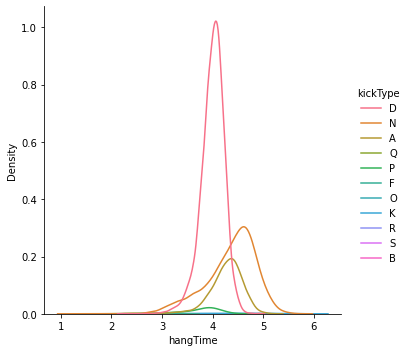

In [71]:
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

kick_types = ['D','F','K','O','P','Q','S','B','N','R','A']

kick_type_names = ['Deep','Flat','Free','Obvious','Pooch','Squib','Surprise','Deep','Normal','Rugby','Aussie']

sns.displot(data = scouting,
            x = "hangTime",
            hue="kickType", 
            kind="kde"
            )

**kick length vs return length**

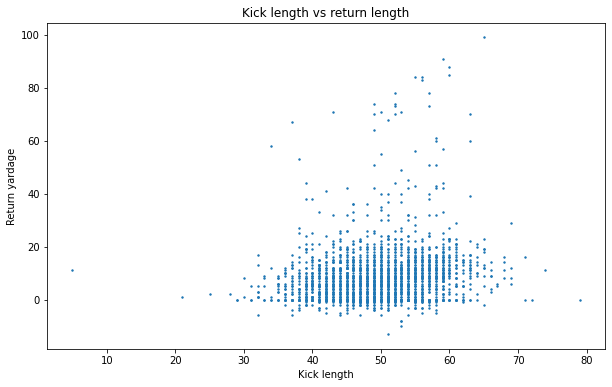

In [61]:
from scipy import stats
# figure
plt.figure(figsize=(10, 6))
# getting data
#kick_length_data = plays["kickLength"]
#kick_return_data = plays["kickReturnYardage"]
# Punt, Field Goal, Punt
kick_type = "Punt"
kick_length_data = plays.loc[(plays["specialTeamsPlayType"] == kick_type), "kickLength"]
kick_return_data = plays.loc[(plays["specialTeamsPlayType"] == kick_type), "kickReturnYardage"]
# plotting
plt.scatter(kick_length_data,kick_return_data,s=2)
#title
plt.title('Kick length vs return length')
plt.xlabel("Kick length")
plt.ylabel("Return yardage")
# showing
plt.show()

In [ ]:
fig = px.scatter(data, x="kickLength", y="kickReturnYardage", color="specialTeamsPlayType")
fig.show()

trying to plot position of players

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
# play
play_2020091000_39 = tracking2020.loc[(tracking2020['playId'] == 3509) & (tracking2020['gameId'] == 2020091310)]

desired_kick = [] # can input distance and kick type?




# fig = go.Figure()

# fig = px.scatter(play_2020091000_39, 
#            x="x", 
#            y="y", 
#            animation_frame="time", 
#            animation_group="nflId",
#            color="team",
#            hover_name="displayName", 
#           )

# fig.show()

interface

In [ ]:
pip install dash

In [90]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="dropdown",
        options=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
        value=['sepal_length', 'sepal_width'],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(dims):
    df = px.data.iris() # replace with your own data source
    fig = px.scatter_matrix(
        df, dimensions=dims, color="species")
    return fig


app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on
